# Metaheuristic course - Session 1

In [29]:
import abc
import random
import time
import numpy as np
from metaheuristics import MetaHeuristic
from typing import Callable, Optional, List

## The MetaHeuristic class

To implement a metaheuristic you only need to create a child class of the `MetaHeuristic` abstract class. Generally this new child class is still an abstract structure that represents a family of heuristics. However, to show the capabilities of the bare `MetaHeuristic` class, let's implement a `DummyHeuristic`.

In [30]:
# A very dummy objective function for testing
def dummy_func(val: float):
    time.sleep(1)
    return val**2


class DummyHeuristic(MetaHeuristic):
    # The solve method takes only the objective function, but you can
    # add as many args or keyword args as you want.
    def solve(self, obj_func: Callable, your_extra_param=None):
        if your_extra_param is not None:
            print(f"Solving using: {your_extra_param}")

        min_val = None
        for i in range(3):
            # Let's make two evaluation each iteration
            val1 = obj_func(2 - i)
            val2 = obj_func(i - 2)

            # Get the min value and update the global min value
            sol, val = (2 - i, val1) if val1 < val2 else (i - 2, val2)
            if min_val is None or val < min_val:
                min_val = val
                # The solve method is a generator, so in each iterarion
                # you should yield the last solution you get (usually
                # the best one) and the value obteined from the obj.
                # function evauation
                yield sol, min_val


dmh = DummyHeuristic()

# The evaluate method runs the heuristic solve method and
# generates an evaluation.
print(dmh.evaluate(dummy_func))

# Setting an obj. function evaluation contraint
print(dmh.evaluate(dummy_func, max_evals=4))

# Setting an iteration contraint (and using custom param)
print(dmh.evaluate(dummy_func, max_evals=4, max_iters=1, your_extra_param="foo"))

# Setting a time contraint
print(dmh.evaluate(dummy_func, max_evals=4, max_iters=1, max_time=0.5))

Evaluating DummyHeuristic
6.008s - Last value: 0 - Last solution: 0                                                           
Evaluation of DummyHeuristic:
  best result --------------- 0
  success ------------------- True
  iters --------------------- 3
  evals --------------------- 6
  time ---------------------- 6.012511968612671
  approx. evals per iter ---- 2.0
  approx. iter time --------- 2.0041706562042236

Evaluating DummyHeuristic
Evaluation of DummyHeuristic: solution: -1                                                          
  best result --------------- -1
  success ------------------- False
  iters --------------------- 2
  evals --------------------- 4
  time ---------------------- 4.00780987739563
  approx. evals per iter ---- 2.0
  approx. iter time --------- 2.003904938697815
  fail reason: 'Obj. function max evaluation exceeded.'

Evaluating DummyHeuristic
Solving using: foo
Evaluation of DummyHeuristic: solution: -2                                               

## The Hill Climbing metaheuristic

The simplest hill climbing metaheuristic takes an initial solution and for each iteration it computes some neighbors of the current solution. Each neighbor is evaluated (using the objective function) and if there is not a new best value found the algorithm stops, if that is not the case, the best solution is updated and continues running another iteration.

Let's implement now a hill climbing metaheuristic class that facilitates the creation of specific hill climbing heuristic implementation. The metaheuristic class will have two principal methods: `get_neighbors` for generating the neighbors of a given solution, and the usual `solve` method.

This class will be an abstract class, however, the `solve` method can be implemented as it is always the same. This only leave the implementation of the `get_neighbors` method to each specific heuristic.

In [31]:
class HillClimbing(MetaHeuristic, abc.ABC):
    @abc.abstractmethod
    def get_neighbors(self, sol) -> List:
        raise NotImplementedError()

    # This method is used if no initial solution is given
    # in the solve method.
    def get_init_sol(self):
        raise NotImplementedError()

    def solve(self, obj_func: Callable, init_sol=None):
        best_sol = self.get_init_sol() if init_sol is None else init_sol
        val = obj_func(best_sol)
        found_best = True
        while found_best:
            new_solutions = self.get_neighbors(best_sol)
            found_best = False
            for sol in new_solutions:
                new_val = obj_func(sol)
                if new_val < val:
                    best_sol = sol
                    val = new_val
                    found_best = True
            yield best_sol, val

### Example hill climbing heuristic implementations

In [32]:
def obj_func(x):
    # Best solution is x = 3
    return (x - 3) ** 2 + 5


class Dummy1DOptimizer(HillClimbing):
    def get_neighbors(self, sol) -> List:
        # Search very close arround sol
        return [sol + (random.random() - 0.5) for _ in range(50)]


dhc = Dummy1DOptimizer()
dhc.evaluate(obj_func, init_sol=256)

Evaluating Dummy1DOptimizer
1.098s - Last value: 5.000002650047745 - Last solution: 2.9983721032756647                          


Evaluation of Dummy1DOptimizer:
  best result --------------- 2.9983721032756647
  success ------------------- True
  iters --------------------- 527
  evals --------------------- 26351
  time ---------------------- 1.0983386039733887
  approx. evals per iter ---- 50.00189753320683
  approx. iter time --------- 0.0020841339733840393

In [33]:
class LessDummy1DOptimizer(HillClimbing):
    def __init__(self):
        self.last_sol = None

    def get_neighbors(self, sol) -> List:
        # Search moving through the gradient
        if self.last_sol is not None and abs(sol - self.last_sol) > 0:
            delta = sol - self.last_sol
            direction = delta / abs(delta)
            neighbors = [sol + direction * random.random() for _ in range(50)]
        else:
            # If there is no gradient, search around the solution
            neighbors = [sol + random.random() - 0.5 for _ in range(50)]
        self.last_sol = sol
        return neighbors


dhc = LessDummy1DOptimizer()
dhc.evaluate(obj_func, init_sol=256)

Evaluating LessDummy1DOptimizer
0.556s - Last value: 5.000004242557514 - Last solution: 3.0020597469540022                          


Evaluation of LessDummy1DOptimizer:
  best result --------------- 3.0020597469540022
  success ------------------- True
  iters --------------------- 261
  evals --------------------- 13051
  time ---------------------- 0.5565524101257324
  approx. evals per iter ---- 50.00383141762452
  approx. iter time --------- 0.0021323847131254118

## Black-box Optimization Benchmarking functions

To test the the metaheuristics implemented in this session we will use 5 of the BBOB noiseless functions. All these functions are defined over $\mathbb{R}^D$ and have $\mathbb{R}$ as image. The search domain of all the functions is $[-5, 5]^D$.

Each function is generated given an optimal solution $x\_opt \in [-5, 5]^D$ and a minimum val $f\_opt$. The value for $f\_opt$ is drawn from a Cauchy distributed
random variable, with zero median and with roughly 50% of the values between -100 and 100. The value is rounded after two decimal places and set to ±1000 if its absolute value exceeds 1000.

To access the BBOB functions you can use the `BBOB` class. For example:

Optimal x is: [ 4.5600171 -2.9231819]
Func. value at x is: 114.38


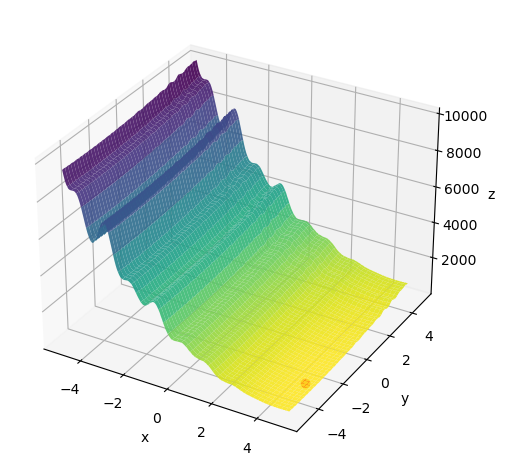

In [34]:
from bbob import BBOB

# Create an instance of BBOB. You can specify a seed for reproducibility.
bbob = BBOB(seed=10)

# This returns and BBOBFunc instance
br_func = bbob.buche_rastrigin_func(dim=2)
print(f"Optimal x is: {br_func.x_opt}")
print(f"Func. value at x is: {br_func.f_opt}")

# Functions of dim = 1 or dim = 2 can be plotted
br_func.plot()

You can also get a function instance with and specific seed

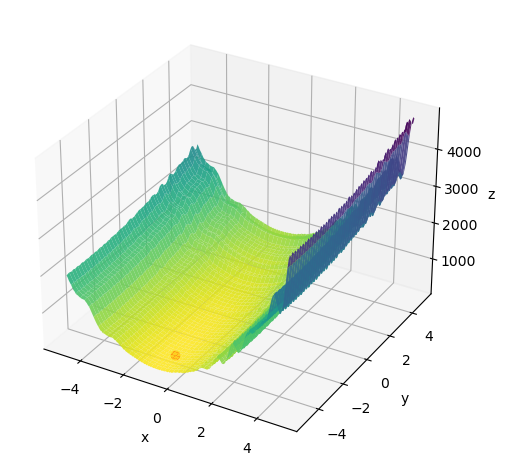

In [35]:
br_func_2 = bbob.buche_rastrigin_func(dim=2, seed=67)
br_func_2.plot()

You can access the objective function using the `func` field, or use the bbob function instance directly.

In [36]:
print(br_func_2.func([1, 4]))
print(br_func_2([1, 4]))

1094.9882409420602
1094.9882409420602


## Testing metaheuristics agains the BBOB functions

The next function takes a `MetaHeuristic` instance and test it against all `BBOB` implemented functions with `dim=2`. You can use it to test your own metaheuristic.

In [37]:
def test_metaheuristic(
    mh: MetaHeuristic,
    max_evals: Optional[int] = None,
    max_iters: Optional[int] = None,
    max_time: Optional[float] = 5,
    *args,
    **kwargs,
):
    bbob = BBOB(seed=10)
    bbob_functions = [
        bbob.sphere_func(dim=2),
        bbob.ellipsodial_func(dim=2),
        bbob.rastrigin_func(dim=2),
        bbob.buche_rastrigin_func(dim=2),
        bbob.linear_slpoe_func(dim=2),
    ]

    for func in bbob_functions:
        print("\nTest\n")
        print(func, end="\n\n")
        ev = mh.evaluate(
            func.func,
            max_evals=max_evals,
            max_iters=max_iters,
            max_time=max_time,
            *args,
            **kwargs,
        )
        print(ev)

        print()
        print(f"Error: {abs(func.f_opt - func(ev.best_result))}")

        try:
            import matplotlib.pyplot as plt
            func.plot(show = False)
            sols = np.array(ev.solutions)
            values = np.array(ev.values)[..., None]
            points = np.hstack((sols, values))
            plt.plot(*list(points.T), '-o', color='blue')
            plt.show()
        except ImportError:
            pass

As an example, let's implement a dummy version of the hill climbing metaheuristic for 2-dimensional functions and test it:


Test

BBOB sphere function instance:
  dim:    2
  x_opt:  [ 4.5600171 -2.9231819]
  f_opt:  114.38

Evaluating Dummy2DOptimizer
0.081s - Last value: 114.38018791879601 - Last solution: [ 4.55054971 -2.9330959 ]                  
Evaluation of Dummy2DOptimizer:
  best result --------------- [ 4.55054971 -2.9330959 ]
  success ------------------- True
  iters --------------------- 12
  evals --------------------- 601
  time ---------------------- 0.08269858360290527
  approx. evals per iter ---- 50.083333333333336
  approx. iter time --------- 0.0068915486335754395


Error: 0.00018791879601565142


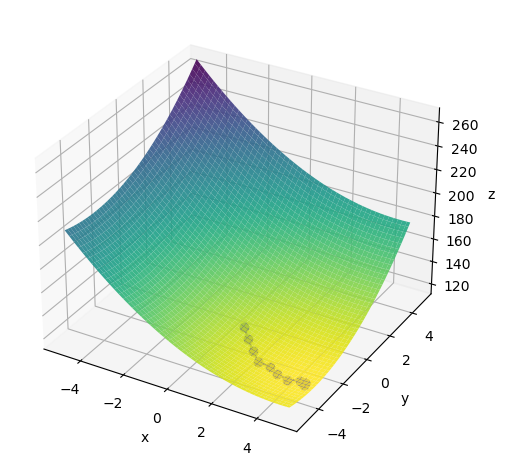


Test

BBOB ellipsodial function instance:
  dim:    2
  x_opt:  [ 4.5600171 -2.9231819]
  f_opt:  114.38

Evaluating Dummy2DOptimizer
0.040s - Last value: 114.9146635515754 - Last solution: [ 2.01743251 -2.9180808 ]                   
Evaluation of Dummy2DOptimizer:
  best result --------------- [ 2.01743251 -2.9180808 ]
  success ------------------- True
  iters --------------------- 6
  evals --------------------- 301
  time ---------------------- 0.042886972427368164
  approx. evals per iter ---- 50.166666666666664
  approx. iter time --------- 0.007147828737894694


Error: 0.5346635515754059


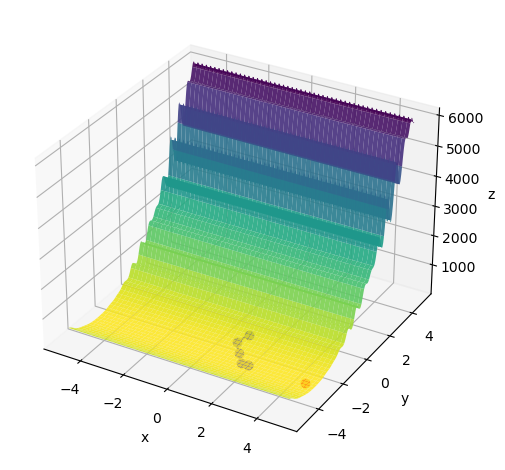


Test

BBOB rastrigin function instance:
  dim:    2
  x_opt:  [ 4.5600171 -2.9231819]
  f_opt:  114.38

Evaluating Dummy2DOptimizer
0.043s - Last value: 140.12188725558934 - Last solution: [-0.51290134 -2.94403531]                  
Evaluation of Dummy2DOptimizer:
  best result --------------- [-0.51290134 -2.94403531]
  success ------------------- True
  iters --------------------- 3
  evals --------------------- 151
  time ---------------------- 0.04424858093261719
  approx. evals per iter ---- 50.333333333333336
  approx. iter time --------- 0.014749526977539062


Error: 25.741887255589347


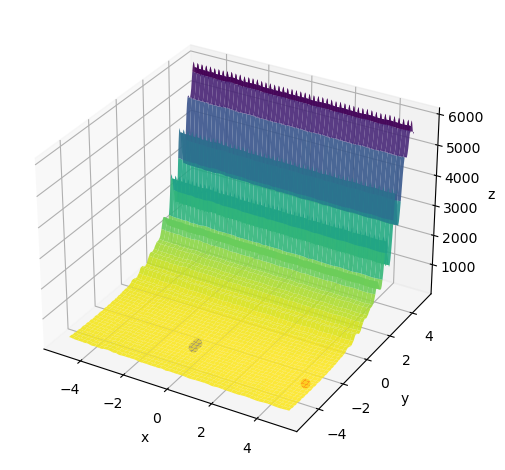


Test

BBOB buche-rastrigin function instance:
  dim:    2
  x_opt:  [ 4.5600171 -2.9231819]
  f_opt:  114.38

Evaluating Dummy2DOptimizer
0.115s - Last value: 122.9086306249248 - Last solution: [ 4.46639446 -2.25014663]                   
Evaluation of Dummy2DOptimizer:
  best result --------------- [ 4.46639446 -2.25014663]
  success ------------------- True
  iters --------------------- 12
  evals --------------------- 601
  time ---------------------- 0.1172018051147461
  approx. evals per iter ---- 50.083333333333336
  approx. iter time --------- 0.009766817092895508


Error: 8.528630624924801


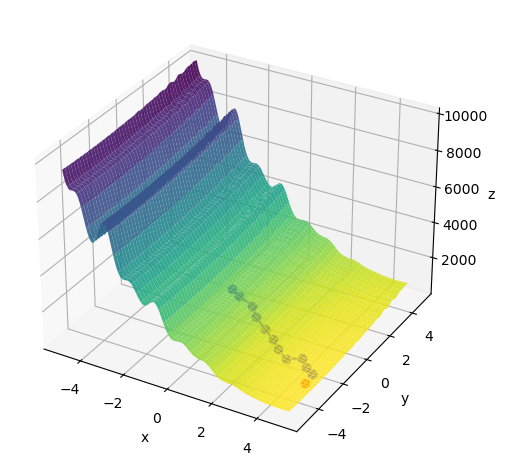


Test

BBOB linear slope function instance:
  dim:    2
  x_opt:  [ 5. -5.]
  f_opt:  114.38

Evaluating Dummy2DOptimizer
0.109s - Last value: 114.38 - Last solution: [ 5. -5.]                                              
Evaluation of Dummy2DOptimizer:
  best result --------------- [ 5. -5.]
  success ------------------- True
  iters --------------------- 13
  evals --------------------- 651
  time ---------------------- 0.11024188995361328
  approx. evals per iter ---- 50.07692307692308
  approx. iter time --------- 0.008480145381047176


Error: 0.0


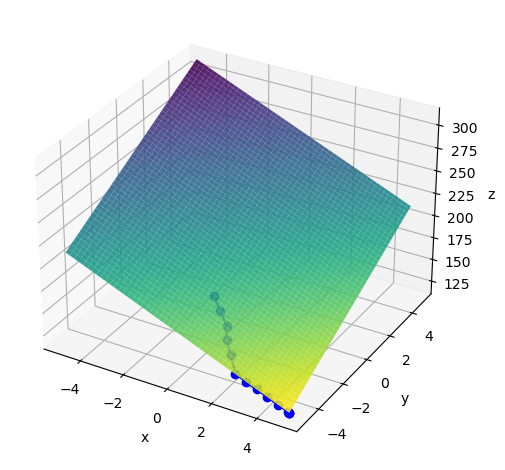

In [38]:
class Dummy2DOptimizer(HillClimbing):
    def __init__(self, seed: Optional[int] = None):
        self.rng = np.random.default_rng(seed=seed)

    def get_init_sol(self):
        return (self.rng.random(2) - 0.5) * 5

    # Each BBOB function dimension range is from -5 to 5
    def _clamp_sol(self, sol: np.ndarray) -> np.ndarray:
        sol[sol > 5] = 5
        sol[sol < -5] = -5
        return sol

    def get_neighbors(self, sol) -> List:
        neighbors = [
            self._clamp_sol(sol + self.rng.random(2) - 0.5) for _ in range(50)
        ]
        self.last_sol = sol
        return neighbors


test_metaheuristic(Dummy2DOptimizer(seed=0))

## Time to code

Using all this tools implement now a metaheuristic (or an heuristic based on the hill climing metaheuristic) which finds the minimun value of the functions of `BBOB`.


Test

BBOB sphere function instance:
  dim:    2
  x_opt:  [ 4.5600171 -2.9231819]
  f_opt:  114.38

Evaluating SimulatedAnnealing2D
Evaluation of SimulatedAnnealing2D:013 - Last solution: [ 4.53424591 -2.95480221]                   
  best result --------------- [ 4.06785292 -2.75559298]
  success ------------------- False
  iters --------------------- 800
  evals --------------------- 40051
  time ---------------------- 5.0005576610565186
  approx. evals per iter ---- 50.06375
  approx. iter time --------- 0.006250697076320648
  fail reason: 'Max time exceeded.'


Error: 0.27031162223332217


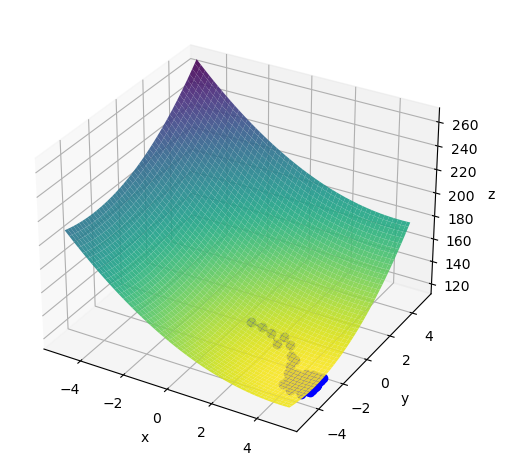


Test

BBOB ellipsodial function instance:
  dim:    2
  x_opt:  [ 4.5600171 -2.9231819]
  f_opt:  114.38

Evaluating SimulatedAnnealing2D
                                                                                                    Evaluation of SimulatedAnnealing2D:
  best result --------------- [ 3.59950323 -2.93046955]
  success ------------------- False
  iters --------------------- 621
  evals --------------------- 31101
  time ---------------------- 5.001506567001343
  approx. evals per iter ---- 50.08212560386473
  approx. iter time --------- 0.008053955824478813
  fail reason: 'Max time exceeded.'


Error: 0.10387929833824217


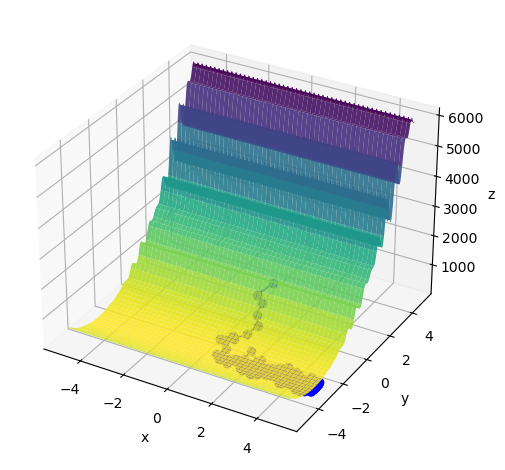


Test

BBOB rastrigin function instance:
  dim:    2
  x_opt:  [ 4.5600171 -2.9231819]
  f_opt:  114.38

Evaluating SimulatedAnnealing2D
Evaluation of SimulatedAnnealing2D:2205 - Last solution: [ 3.76100636 -2.23453604]                  
  best result --------------- [ 3.76100636 -2.23453604]
  success ------------------- False
  iters --------------------- 385
  evals --------------------- 19282
  time ---------------------- 5.000077247619629
  approx. evals per iter ---- 50.08311688311688
  approx. iter time --------- 0.012987213630180855
  fail reason: 'Max time exceeded.'


Error: 11.099894656722057


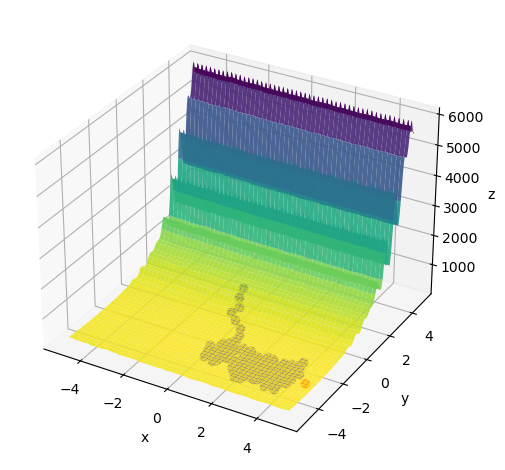


Test

BBOB buche-rastrigin function instance:
  dim:    2
  x_opt:  [ 4.5600171 -2.9231819]
  f_opt:  114.38

Evaluating SimulatedAnnealing2D
2.641s - Last value: 140.05592396104612 - Last solution: [ 4.41972989 -2.01974466]                  
Evaluation of SimulatedAnnealing2D:
  best result --------------- [ 4.41972989 -2.01974466]
  success ------------------- True
  iters --------------------- 242
  evals --------------------- 12101
  time ---------------------- 2.6418561935424805
  approx. evals per iter ---- 50.00413223140496
  approx. iter time --------- 0.010916761130340829


Error: 25.675923961046124


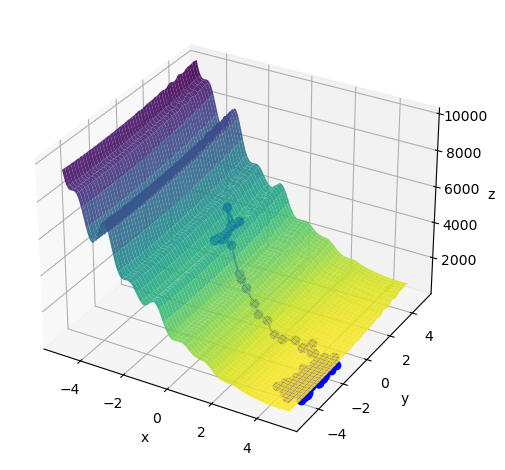


Test

BBOB linear slope function instance:
  dim:    2
  x_opt:  [ 5. -5.]
  f_opt:  114.38

Evaluating SimulatedAnnealing2D
0.708s - Last value: 114.38 - Last solution: [ 5. -5.]                                              
Evaluation of SimulatedAnnealing2D:
  best result --------------- [ 5. -5.]
  success ------------------- True
  iters --------------------- 45
  evals --------------------- 2251
  time ---------------------- 0.7115890979766846
  approx. evals per iter ---- 50.022222222222226
  approx. iter time --------- 0.015813091066148546


Error: 0.0


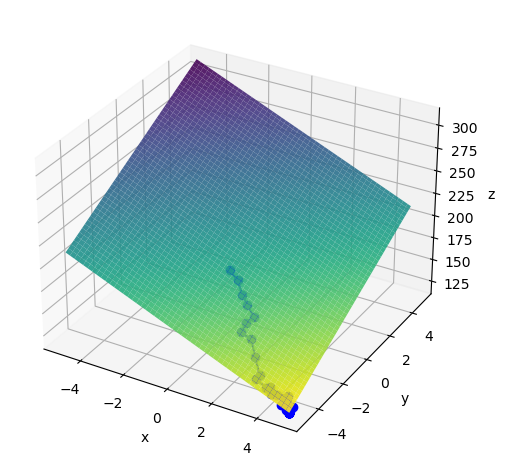

In [39]:
from random import random

class SimulatedAnnealing2D(Dummy2DOptimizer):
    def __init__(self, seed: Optional[int] = None):
        self.rng = np.random.default_rng(seed=seed)

    def solve(self, obj_func: Callable, init_sol=None, alpha=0.1, beta=0.01):
        best_sol = self.get_init_sol() if init_sol is None else init_sol
        val = obj_func(best_sol)
        found_best = True
        while found_best:
            new_solutions = self.get_neighbors(best_sol)
            found_best = False
            for sol in new_solutions:
                new_val = obj_func(sol)
                if new_val < val:
                    best_sol = sol
                    val = new_val
                    found_best = True
                elif random() < alpha: # Pick a not optimal choise with a certain probability
                    best_sol = sol
                    val = new_val

            if random() < beta: # Decrease beta value with a certain probability
                beta -= random()/10

            yield best_sol, val

test_metaheuristic(SimulatedAnnealing2D(seed=0))


Test

BBOB sphere function instance:
  dim:    2
  x_opt:  [ 4.5600171 -2.9231819]
  f_opt:  114.38

Evaluating TabuSearch2D
0.005s - Last value: 132.53763538810176 - Last solution: [ 0.68480844 -1.15106643]                  
Evaluation of TabuSearch2D:
  best result --------------- [ 0.68480844 -1.15106643]
  success ------------------- True
  iters --------------------- 1
  evals --------------------- 51
  time ---------------------- 0.019803285598754883
  approx. evals per iter ---- 51.0
  approx. iter time --------- 0.019803285598754883


Error: 18.157635388101767


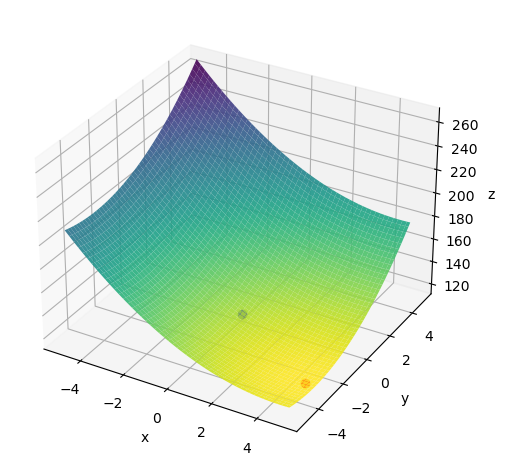


Test

BBOB ellipsodial function instance:
  dim:    2
  x_opt:  [ 4.5600171 -2.9231819]
  f_opt:  114.38

Evaluating TabuSearch2D
0.004s - Last value: 2916.236387748071 - Last solution: [1.50940289 2.1176508 ]                     
Evaluation of TabuSearch2D:
  best result --------------- [1.50940289 2.1176508 ]
  success ------------------- True
  iters --------------------- 1
  evals --------------------- 51
  time ---------------------- 0.008258819580078125
  approx. evals per iter ---- 51.0
  approx. iter time --------- 0.008258819580078125


Error: 2801.856387748071


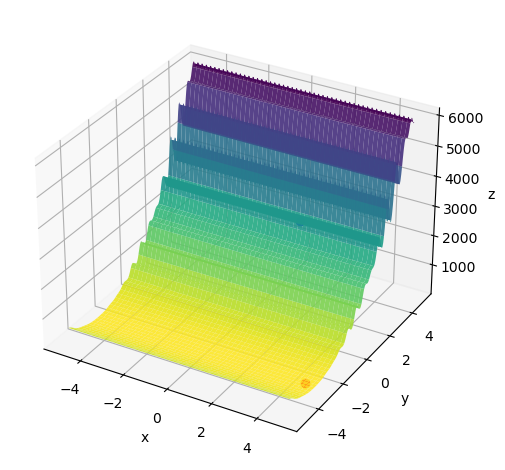


Test

BBOB rastrigin function instance:
  dim:    2
  x_opt:  [ 4.5600171 -2.9231819]
  f_opt:  114.38

Evaluating TabuSearch2D
0.015s - Last value: 505.1996929588648 - Last solution: [0.38843946 0.51119588]                     
Evaluation of TabuSearch2D:
  best result --------------- [0.38843946 0.51119588]
  success ------------------- True
  iters --------------------- 1
  evals --------------------- 51
  time ---------------------- 0.015829086303710938
  approx. evals per iter ---- 51.0
  approx. iter time --------- 0.015829086303710938


Error: 390.8196929588648


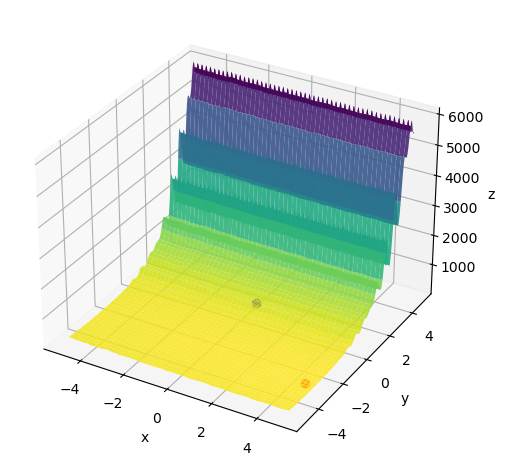


Test

BBOB buche-rastrigin function instance:
  dim:    2
  x_opt:  [ 4.5600171 -2.9231819]
  f_opt:  114.38

Evaluating TabuSearch2D
0.009s - Last value: 2249.249260710207 - Last solution: [0.16080237 1.56622048]                     
Evaluation of TabuSearch2D:
  best result --------------- [0.16080237 1.56622048]
  success ------------------- True
  iters --------------------- 1
  evals --------------------- 51
  time ---------------------- 0.011652469635009766
  approx. evals per iter ---- 51.0
  approx. iter time --------- 0.011652469635009766


Error: 2134.869260710207


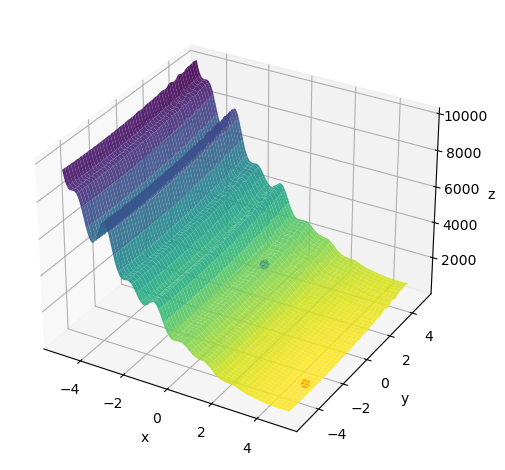


Test

BBOB linear slope function instance:
  dim:    2
  x_opt:  [ 5. -5.]
  f_opt:  114.38

Evaluating TabuSearch2D
0.006s - Last value: 235.0432358888956 - Last solution: [-1.63443181  0.43189177]                   
Evaluation of TabuSearch2D:
  best result --------------- [-1.63443181  0.43189177]
  success ------------------- True
  iters --------------------- 1
  evals --------------------- 51
  time ---------------------- 0.0073053836822509766
  approx. evals per iter ---- 51.0
  approx. iter time --------- 0.0073053836822509766


Error: 120.6632358888956


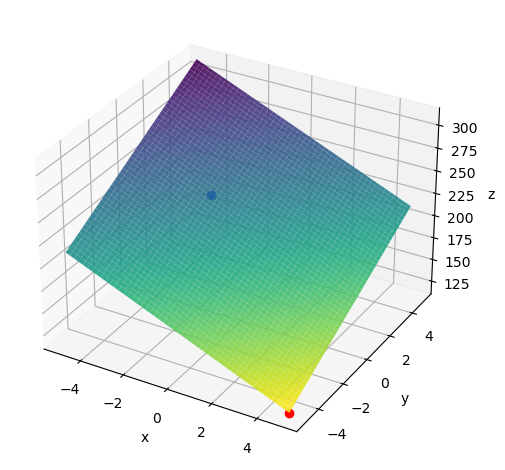

In [54]:
class TabuSearch2D(Dummy2DOptimizer):
    def __init__(self, seed: Optional[int] = None, tabu_memory_limit_size: int = 10000):
        self.tabu_memory_limit_size = tabu_memory_limit_size
        self.rng = np.random.default_rng(seed=seed)

    def solve(self, obj_func: Callable, init_sol=None):
        best_sol = self.get_init_sol() if init_sol is None else init_sol
        val = obj_func(best_sol)
        tabu_memory = [best_sol] # Add simple Tabu Search Memory
        found_best = True
        while found_best:
            new_solutions = self.get_neighbors(best_sol)
            found_best = False
            for sol in new_solutions:
                new_val = obj_func(sol)
                if new_val < val and not self._is_in_memory(sol, tabu_memory):
                    best_sol = sol
                    val = new_val
                    tabu_memory.append(best_sol) # Add to Tabu Memory
                    if len(tabu_memory) > self.tabu_memory_limit_size: # If Tabu Memory is full, then remove oldest data
                        tabu_memory.remove(tabu_memory[0])
                    found_best = True

            yield best_sol, val

    def _is_in_memory(self, value, memory):
        for elem in memory:
            if elem[0] == value[0] and elem[1] == value[1]:
                return True
        return False


test_metaheuristic(TabuSearch2D(seed=0))